CIFAR

In [1]:
import torch
import os
import opacus
import copy
import torchvision
import torchattacks

import numpy as np
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime
from opacus.validators import ModuleValidator


from model import ResNet9, initialize_weights
from torchvision import models


CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD_DEV = (0.2023, 0.1994, 0.2010)

def accuracy(preds, labels):
    return (preds == labels).mean()

class Experiment:
    def __init__(self, batch_size, epochs, patience, adv_attack, adv_attack_mode, epsilon, dp, device, save_experiment,
                 verbose, adv_test=True, name=None):
        # self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        self.model = ResNet9(norm_layer="group")
        self.adv_model = ResNet9(norm_layer="group").to(device)
        self.optimizer = optim.NAdam(self.model.parameters())
        self.criterion = nn.CrossEntropyLoss()
        self.batch_size = batch_size
        self.epochs = epochs
        self.patience = patience
        self.adv_attack = adv_attack
        self.adv_attack_mode = adv_attack_mode
        self.epsilon = epsilon
        self.dp = dp
        self.device = device
        self.verbose = verbose
        self.disable_tqdm = not self.verbose
        self.save_experiment = save_experiment
        self.adv_test = adv_test
        self.best_model_weights = None

        if name is None:
            adv_s = f"adv-{epsilon}-{adv_attack_mode}" if adv_attack is not None else "non_adv"
            dp_s = "dp" if dp else "non_dp"
            self.name = f"{adv_s}+{dp_s}+{batch_size}"
        else:
            self.name = name

        now = datetime.now()
        formatted_timestamp = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.dir_name = f"results/{self.name}_{formatted_timestamp}"
        if self.save_experiment:
            os.makedirs(self.dir_name, exist_ok=True)

        self._setup_training()

    def _log(self, message):
        # if self.verbose:
        print(f"Experiment {self.name}: {message}")

    def _setup_training(self):
        self._log("Loading data")
        transform = transforms.Compose(
            [transforms.ToTensor(),
              transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD_DEV)
             ])
        
        learning_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

        self.train_loader = torch.utils.data.DataLoader(learning_set, batch_size=self.batch_size, shuffle=True, num_workers=2)

        test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        self.test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=2)

        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

        if self.dp:
            self._log("DP on")
            self.privacy_engine = opacus.PrivacyEngine()
            self.model = ModuleValidator.fix(self.model)
            self.optimizer = optim.NAdam(self.model.parameters())
            self.model, self.optimizer, self.train_loader = self.privacy_engine.make_private_with_epsilon(
                module=self.model,
                optimizer=self.optimizer,
                data_loader=self.train_loader,
                epochs=self.epochs,
                target_epsilon=7.5,
                target_delta=1e-5,
                max_grad_norm=1.2,
            )
        else:
            self._log("DP off")
            
    
    def _fgsm_attack_per_sample(self, inputs, targets):
        inputs, targets = inputs.to(self.device), targets.to(self.device)
        adv_images = torch.empty_like(inputs)
        if self.dp:
            self.adv_model.load_state_dict(copy.deepcopy(self.model._module.state_dict()))
            attack = torchattacks.FGSM(self.adv_model, eps=self.epsilon)
        else:
            attack = torchattacks.FGSM(self.model, eps=self.epsilon)
        for i in range(len(inputs)):
            sample = torch.unsqueeze(inputs[i], dim=0)
            sample_target = targets[i:i + 1]

            # plt.imshow(np.transpose(sample.squeeze().detach().cpu().numpy(), (1, 2, 0)))
            # plt.show()
            # plt.imshow(np.transpose(adv_image.squeeze().detach().cpu().numpy(), (1, 2, 0)))
            # plt.show()
            adv_images[i] = attack(sample, sample_target)

        # imshow(torchvision.utils.make_grid(adv_images).cpu())
        # imshow(torchvision.utils.make_grid(inputs).cpu())
        # print(' '.join(f'{classes[targets[j]]:5s}' for j in range(BATCH_SIZE)))

        adv_images.to(self.device)
        # print(adv_images.shape, inputs.shape)
        return adv_images, targets

    def _fgsm_attack_batch(self, inputs, targets):
        inputs, targets = inputs.to(self.device), targets.to(self.device)
        if self.dp:
            self.adv_model.load_state_dict(copy.deepcopy(self.model._module.state_dict()))
            attack = torchattacks.FGSM(self.adv_model, eps=self.epsilon)
        else:
            attack = torchattacks.FGSM(self.model, eps=self.epsilon)
    
        perturbed_inputs = attack(inputs, targets)
        
#         plt.imshow(np.transpose(torchvision.utils.make_grid(perturbed_inputs).cpu().numpy(), (1, 2, 0)))
#         plt.show()
#         plt.imshow(np.transpose(torchvision.utils.make_grid(inputs).cpu().numpy(), (1, 2, 0)))
#         plt.show()
#         print(' '.join(f'{self.classes[targets[j]]:5s}' for j in range(self.batch_size)))
        
        return perturbed_inputs, targets

    def _run_epoch(self, data_loader):
        self.model.train()

        losses = []
        top1_acc = []

        for inputs, targets in tqdm(data_loader, disable=self.disable_tqdm):
            if self.adv_attack:
                if self.adv_attack_mode == 'batch':
                    inputs, targets = self._fgsm_attack_batch(inputs, targets)
                else:
                    inputs, targets = self._fgsm_attack_per_sample(inputs, targets)
            else:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

            self.optimizer.zero_grad()

            output = self.model(inputs)
            loss = self.criterion(output, targets)
            
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = targets.detach().cpu().numpy()

            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            self.optimizer.step()
            
        epsilon = self.privacy_engine.get_epsilon(1e-5)
        print(epsilon)
        return np.mean(losses), np.mean(top1_acc)


    def _fit(self):
        self._log("Training started")
        _ = self.model.to(self.device)
        _ = self.model.apply(initialize_weights)

        curr_patience = 0
        max_acc = 0

        val_losses = []
        val_accuracies = []
        train_losses = []
        train_accuracies = []

        for epoch in range(self.epochs):

            train_loss, train_acc = self._run_epoch(self.train_loader)
            self._log(f"Epoch {epoch + 1: >3}/{self.epochs}, train loss: {train_loss:.2e}, train acc: {train_acc:.3f}")

            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            
            if train_acc > max_acc:
                max_acc = train_acc
                self.best_model_weights = copy.deepcopy(self.model.state_dict())
                if self.save_experiment:
                    torch.save(self.model.state_dict(), f"{self.dir_name}/{self.name}.pt")

        self.model.load_state_dict(self.best_model_weights)

        self._log("Training finished")
        epsilon = self.privacy_engine.get_epsilon(1e-5)
        print(epsilon)

        plt.plot(range(len(train_losses)), np.array(train_losses))
        plt.title('train loss')
        if self.save_experiment:
            plt.savefig(f"{self.dir_name}/train_loss.png")
        if self.verbose:
            plt.show()
        else:
            plt.clf()

        plt.plot(range(len(train_accuracies)), np.array(train_accuracies))
        plt.title('train acc')
        if self.save_experiment:
            plt.savefig(f"{self.dir_name}/train_acc.png")
        if self.verbose:
            plt.show()
        else:
            plt.clf()

    def _validate(self, data_loader):
        self.model.eval()
        epoch_acc = 0.0
        epoch_acc_top5 = 0.0
        epoch_loss = 0.0

        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)

                loss = self.criterion(outputs, targets)

                top1 = torch.argmax(outputs, dim=1).long()
                n_correct = torch.sum(top1 == targets)

                _, top5 = torch.topk(outputs, 5, dim=1)
                top5 = top5.t()
                correct = top5.eq(targets.reshape(1, -1).expand_as(top5))
                n_correct_top5 = correct[:5].reshape(-1).float().sum(0, keepdim=True)

                epoch_loss += loss.item()
                epoch_acc += n_correct.item()
                epoch_acc_top5 += n_correct_top5.item()

            epoch_loss /= len(data_loader.dataset)
            epoch_acc /= len(data_loader.dataset)
            epoch_acc_top5 /= len(data_loader.dataset)

        return epoch_loss, epoch_acc, epoch_acc_top5

    def test(self, eps, data_loader):
        correct = 0
        adv_examples = []
        self.model.eval()

        if self.dp:
            self.adv_model.load_state_dict(copy.deepcopy(self.model._module.state_dict()))
            attack = torchattacks.FGSM(self.adv_model, eps=eps)
        else:
            attack = torchattacks.FGSM(self.model, eps=eps)

        for data, target in tqdm(data_loader, disable=self.disable_tqdm):
            data, target = data.to(self.device), target.to(self.device)

            output = self.model(data)
            init_pred = torch.argmax(output, dim=1).long()

            if init_pred.item() != target.item():
                continue

            perturbed_inputs = attack(data, target)
            output = self.model(perturbed_inputs)

            final_pred = torch.argmax(output, dim=1).long()
            if final_pred.item() == target.item():
                correct += 1

                if (eps == 0) and (len(adv_examples) < 5):
                    adv_ex = perturbed_inputs.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
            else:
                if len(adv_examples) < 5:
                    adv_ex = perturbed_inputs.squeeze().detach().cpu().numpy()
                    adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

        final_acc = correct / float(len(data_loader))
        self._log(
            "Epsilon: {}\tTest Accuracy = {} / {} = {}".format(eps, correct, len(data_loader), final_acc))
        return final_acc, adv_examples

cuda
Experiment non_adv+dp+256: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment non_adv+dp+256: DP on


/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Experiment non_adv+dp+256: Training started


  0%|                                                     | 0/196 [00:00<?, ?it/s]/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|███████████████████████████████████████████| 196/196 [00:15<00:00, 12.46it/s]


2.571564908530721
Experiment non_adv+dp+256: Epoch   1/50, train loss: 1.95e+00, train acc: 0.353


100%|███████████████████████████████████████████| 196/196 [00:14<00:00, 13.46it/s]


2.8116196368474746
Experiment non_adv+dp+256: Epoch   2/50, train loss: 1.73e+00, train acc: 0.443


100%|███████████████████████████████████████████| 196/196 [00:14<00:00, 13.45it/s]


3.0044987202691504
Experiment non_adv+dp+256: Epoch   3/50, train loss: 1.70e+00, train acc: 0.477


100%|███████████████████████████████████████████| 196/196 [00:19<00:00, 10.11it/s]


3.1725618832035467
Experiment non_adv+dp+256: Epoch   4/50, train loss: 1.68e+00, train acc: 0.494


100%|███████████████████████████████████████████| 196/196 [00:19<00:00, 10.14it/s]


3.3273767737363005
Experiment non_adv+dp+256: Epoch   5/50, train loss: 1.69e+00, train acc: 0.512


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.03it/s]


3.4711808388143726
Experiment non_adv+dp+256: Epoch   6/50, train loss: 1.68e+00, train acc: 0.522


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.97it/s]


3.606082377552215
Experiment non_adv+dp+256: Epoch   7/50, train loss: 1.68e+00, train acc: 0.534


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.97it/s]


3.7365856603782093
Experiment non_adv+dp+256: Epoch   8/50, train loss: 1.69e+00, train acc: 0.545


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.01it/s]


3.8608192274863686
Experiment non_adv+dp+256: Epoch   9/50, train loss: 1.69e+00, train acc: 0.552


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.98it/s]


3.980680454334303
Experiment non_adv+dp+256: Epoch  10/50, train loss: 1.69e+00, train acc: 0.555


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.09it/s]


4.099751548642113
Experiment non_adv+dp+256: Epoch  11/50, train loss: 1.67e+00, train acc: 0.567


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.98it/s]


4.210875182321701
Experiment non_adv+dp+256: Epoch  12/50, train loss: 1.67e+00, train acc: 0.573


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.99it/s]


4.321998816001289
Experiment non_adv+dp+256: Epoch  13/50, train loss: 1.65e+00, train acc: 0.580


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.00it/s]


4.431974657592358
Experiment non_adv+dp+256: Epoch  14/50, train loss: 1.67e+00, train acc: 0.580


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.00it/s]


4.53575106358673
Experiment non_adv+dp+256: Epoch  15/50, train loss: 1.66e+00, train acc: 0.585


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.02it/s]


4.639527469581102
Experiment non_adv+dp+256: Epoch  16/50, train loss: 1.66e+00, train acc: 0.590


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.01it/s]


4.743303875575474
Experiment non_adv+dp+256: Epoch  17/50, train loss: 1.67e+00, train acc: 0.590


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.99it/s]


4.84220310065195
Experiment non_adv+dp+256: Epoch  18/50, train loss: 1.68e+00, train acc: 0.593


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.99it/s]


4.9396665157530775
Experiment non_adv+dp+256: Epoch  19/50, train loss: 1.64e+00, train acc: 0.602


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.02it/s]


5.037129930854204
Experiment non_adv+dp+256: Epoch  20/50, train loss: 1.64e+00, train acc: 0.608


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.00it/s]


5.134593345955332
Experiment non_adv+dp+256: Epoch  21/50, train loss: 1.63e+00, train acc: 0.613


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.01it/s]


5.226954030986269
Experiment non_adv+dp+256: Epoch  22/50, train loss: 1.64e+00, train acc: 0.612


100%|███████████████████████████████████████████| 196/196 [00:33<00:00,  5.93it/s]


5.318888022284712
Experiment non_adv+dp+256: Epoch  23/50, train loss: 1.63e+00, train acc: 0.614


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.00it/s]


5.410822013583157
Experiment non_adv+dp+256: Epoch  24/50, train loss: 1.63e+00, train acc: 0.619


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.98it/s]


5.502756004881601
Experiment non_adv+dp+256: Epoch  25/50, train loss: 1.64e+00, train acc: 0.619


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.99it/s]


5.591822927635452
Experiment non_adv+dp+256: Epoch  26/50, train loss: 1.64e+00, train acc: 0.621


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.99it/s]


5.678831834474527
Experiment non_adv+dp+256: Epoch  27/50, train loss: 1.63e+00, train acc: 0.621


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.00it/s]


5.765840741313602
Experiment non_adv+dp+256: Epoch  28/50, train loss: 1.62e+00, train acc: 0.626


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.01it/s]


5.852849648152678
Experiment non_adv+dp+256: Epoch  29/50, train loss: 1.61e+00, train acc: 0.626


100%|███████████████████████████████████████████| 196/196 [00:14<00:00, 13.25it/s]


5.939858554991754
Experiment non_adv+dp+256: Epoch  30/50, train loss: 1.61e+00, train acc: 0.627


100%|███████████████████████████████████████████| 196/196 [00:14<00:00, 13.41it/s]


6.0236967157310515
Experiment non_adv+dp+256: Epoch  31/50, train loss: 1.63e+00, train acc: 0.629


100%|███████████████████████████████████████████| 196/196 [00:17<00:00, 11.05it/s]


6.106254748145406
Experiment non_adv+dp+256: Epoch  32/50, train loss: 1.63e+00, train acc: 0.635


100%|███████████████████████████████████████████| 196/196 [00:17<00:00, 11.17it/s]


6.188812780559761
Experiment non_adv+dp+256: Epoch  33/50, train loss: 1.59e+00, train acc: 0.640


100%|███████████████████████████████████████████| 196/196 [00:17<00:00, 11.05it/s]


6.271370812974117
Experiment non_adv+dp+256: Epoch  34/50, train loss: 1.61e+00, train acc: 0.636


100%|███████████████████████████████████████████| 196/196 [00:17<00:00, 11.20it/s]


6.353928845388471
Experiment non_adv+dp+256: Epoch  35/50, train loss: 1.59e+00, train acc: 0.640


100%|███████████████████████████████████████████| 196/196 [00:14<00:00, 13.29it/s]


6.435435581784149
Experiment non_adv+dp+256: Epoch  36/50, train loss: 1.62e+00, train acc: 0.637


100%|███████████████████████████████████████████| 196/196 [00:14<00:00, 13.43it/s]


6.513921042620267
Experiment non_adv+dp+256: Epoch  37/50, train loss: 1.61e+00, train acc: 0.638


100%|███████████████████████████████████████████| 196/196 [00:18<00:00, 10.76it/s]


6.592406503456385
Experiment non_adv+dp+256: Epoch  38/50, train loss: 1.59e+00, train acc: 0.644


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.95it/s]


6.670891964292503
Experiment non_adv+dp+256: Epoch  39/50, train loss: 1.58e+00, train acc: 0.644


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.08it/s]


6.74937742512862
Experiment non_adv+dp+256: Epoch  40/50, train loss: 1.59e+00, train acc: 0.648


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.00it/s]


6.827862885964739
Experiment non_adv+dp+256: Epoch  41/50, train loss: 1.61e+00, train acc: 0.648


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.00it/s]


6.905810466841105
Experiment non_adv+dp+256: Epoch  42/50, train loss: 1.59e+00, train acc: 0.650


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.98it/s]


6.980529936004733
Experiment non_adv+dp+256: Epoch  43/50, train loss: 1.57e+00, train acc: 0.656


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.95it/s]


7.055249405168361
Experiment non_adv+dp+256: Epoch  44/50, train loss: 1.58e+00, train acc: 0.651


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.99it/s]


7.129968874331989
Experiment non_adv+dp+256: Epoch  45/50, train loss: 1.58e+00, train acc: 0.653


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  6.02it/s]


7.204688343495617
Experiment non_adv+dp+256: Epoch  46/50, train loss: 1.59e+00, train acc: 0.651


100%|███████████████████████████████████████████| 196/196 [00:32<00:00,  5.98it/s]


7.279407812659245
Experiment non_adv+dp+256: Epoch  47/50, train loss: 1.57e+00, train acc: 0.651


100%|███████████████████████████████████████████| 196/196 [00:19<00:00,  9.86it/s]


7.354127281822873
Experiment non_adv+dp+256: Epoch  48/50, train loss: 1.59e+00, train acc: 0.654


100%|███████████████████████████████████████████| 196/196 [00:14<00:00, 13.39it/s]


7.427916337531441
Experiment non_adv+dp+256: Epoch  49/50, train loss: 1.56e+00, train acc: 0.656


100%|███████████████████████████████████████████| 196/196 [00:14<00:00, 13.31it/s]


7.499121994359426
Experiment non_adv+dp+256: Epoch  50/50, train loss: 1.57e+00, train acc: 0.657
Experiment non_adv+dp+256: Training finished
7.499121994359426


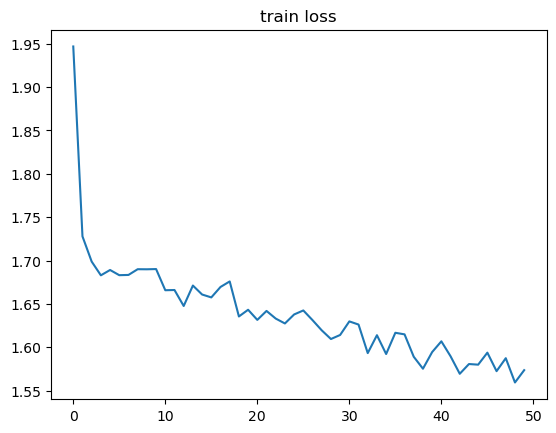

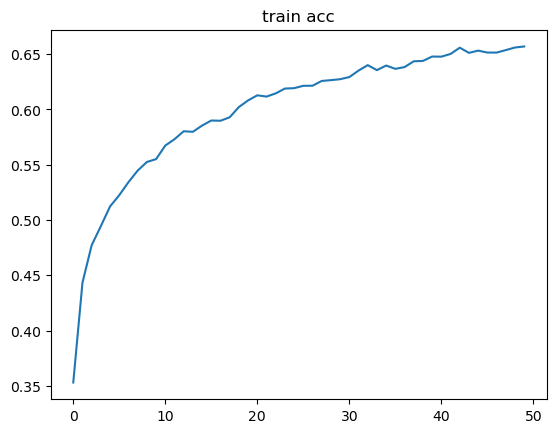

TypeError: 'NoneType' object is not callable

In [2]:
import torch
# max 1.5 eps 7.5
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

batch_size=256
adv_attack_mode ='batch'
epsilon=0.1
dp=True
epochs = 50
patience = 50
save_experiment=False 
verbose=True

adv_attack = None

experiment = Experiment(
    batch_size=batch_size, 
    epochs=epochs, 
    patience=patience, 
    adv_attack=adv_attack, 
    adv_attack_mode=None, 
    epsilon=epsilon, 
    dp=dp, 
    device=device, 
    save_experiment=save_experiment, 
    verbose=verbose, 
    adv_test=True)

experiment._fit()

In [3]:
experiment._validate(experiment.test_loader)

(1.6778274120069812, 0.6337, 0.9601)

In [4]:
experiment.optimizer.noise_multiplier

0.69549560546875

cuda
Experiment adv-0.1-batch+dp+512: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment adv-0.1-batch+dp+512: DP on


/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Experiment adv-0.1-batch+dp+512: Training started


  0%|                                                                                 | 0/98 [00:00<?, ?it/s]/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  4.92it/s]


3.0303179219862293
Experiment adv-0.1-batch+dp+512: Epoch   1/25, train loss: 2.68e+00, train acc: 0.187


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.30it/s]


3.4061345426138123
Experiment adv-0.1-batch+dp+512: Epoch   2/25, train loss: 2.18e+00, train acc: 0.269


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.25it/s]


3.7044266457317345
Experiment adv-0.1-batch+dp+512: Epoch   3/25, train loss: 2.14e+00, train acc: 0.291


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.21it/s]


3.967152420117926
Experiment adv-0.1-batch+dp+512: Epoch   4/25, train loss: 2.10e+00, train acc: 0.305


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


4.207332408474399
Experiment adv-0.1-batch+dp+512: Epoch   5/25, train loss: 2.08e+00, train acc: 0.307


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.19it/s]


4.431226564402946
Experiment adv-0.1-batch+dp+512: Epoch   6/25, train loss: 2.05e+00, train acc: 0.325


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.14it/s]


4.638358642347773
Experiment adv-0.1-batch+dp+512: Epoch   7/25, train loss: 2.03e+00, train acc: 0.333


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.16it/s]


4.8403803406271715
Experiment adv-0.1-batch+dp+512: Epoch   8/25, train loss: 1.99e+00, train acc: 0.349


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.14it/s]


5.029228964478132
Experiment adv-0.1-batch+dp+512: Epoch   9/25, train loss: 2.00e+00, train acc: 0.351


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.16it/s]


5.215962871438543
Experiment adv-0.1-batch+dp+512: Epoch  10/25, train loss: 1.98e+00, train acc: 0.360


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.15it/s]


5.391119387493792
Experiment adv-0.1-batch+dp+512: Epoch  11/25, train loss: 1.99e+00, train acc: 0.358


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.17it/s]


5.566275903549042
Experiment adv-0.1-batch+dp+512: Epoch  12/25, train loss: 1.96e+00, train acc: 0.370


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.15it/s]


5.732163158563689
Experiment adv-0.1-batch+dp+512: Epoch  13/25, train loss: 1.95e+00, train acc: 0.373


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.15it/s]


5.8954096329390575
Experiment adv-0.1-batch+dp+512: Epoch  14/25, train loss: 1.95e+00, train acc: 0.376


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.15it/s]


6.058589440463286
Experiment adv-0.1-batch+dp+512: Epoch  15/25, train loss: 1.94e+00, train acc: 0.384


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.15it/s]


6.2113225523629225
Experiment adv-0.1-batch+dp+512: Epoch  16/25, train loss: 1.94e+00, train acc: 0.386


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


6.364055664262559
Experiment adv-0.1-batch+dp+512: Epoch  17/25, train loss: 1.92e+00, train acc: 0.387


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.13it/s]


6.516788776162197
Experiment adv-0.1-batch+dp+512: Epoch  18/25, train loss: 1.92e+00, train acc: 0.390


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.11it/s]


6.662127335737449
Experiment adv-0.1-batch+dp+512: Epoch  19/25, train loss: 1.93e+00, train acc: 0.399


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.14it/s]


6.805458292725727
Experiment adv-0.1-batch+dp+512: Epoch  20/25, train loss: 1.90e+00, train acc: 0.403


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.17it/s]


6.948789249714006
Experiment adv-0.1-batch+dp+512: Epoch  21/25, train loss: 1.91e+00, train acc: 0.408


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


7.091674405299863
Experiment adv-0.1-batch+dp+512: Epoch  22/25, train loss: 1.91e+00, train acc: 0.405


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:19<00:00,  5.16it/s]


7.226500073885393
Experiment adv-0.1-batch+dp+512: Epoch  23/25, train loss: 1.91e+00, train acc: 0.410


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.20it/s]


7.361325742470921
Experiment adv-0.1-batch+dp+512: Epoch  24/25, train loss: 1.88e+00, train acc: 0.419


100%|████████████████████████████████████████████████████████████████████████| 98/98 [00:18<00:00,  5.18it/s]


7.4961514110564496
Experiment adv-0.1-batch+dp+512: Epoch  25/25, train loss: 1.89e+00, train acc: 0.420
Experiment adv-0.1-batch+dp+512: Training finished
7.4961514110564496


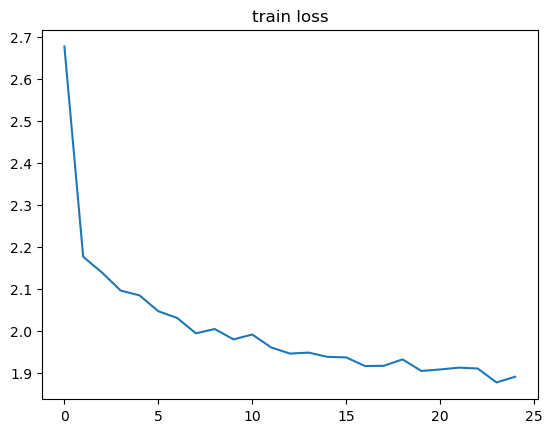

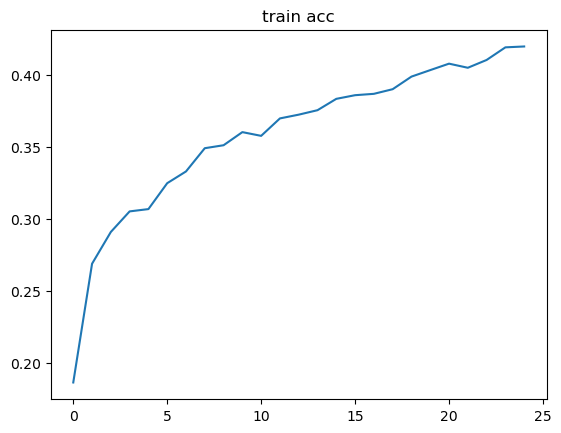

In [2]:
import torch
# max 2 eps 7.5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

batch_size=512
adv_attack_mode ='batch'
epsilon=0.1
dp=True
epochs = 25
patience = 25
save_experiment=False 
verbose=True

adv_attack = True

experiment = Experiment(
    batch_size=batch_size, 
    epochs=epochs, 
    patience=patience, 
    adv_attack=adv_attack, 
    adv_attack_mode=adv_attack_mode, 
    epsilon=epsilon, 
    dp=dp, 
    device=device, 
    save_experiment=save_experiment, 
    verbose=verbose, 
    adv_test=True)

experiment._fit()

In [3]:
experiment._validate(experiment.test_loader)

(4.370759160028823, 0.3185, 0.7666)

cuda
Experiment non_adv+dp+2048: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment non_adv+dp+2048: DP on


/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Experiment non_adv+dp+2048: Training started


  0%|                                                                           | 0/25 [00:00<?, ?it/s]/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.54it/s]


2.302368946645646
Experiment non_adv+dp+2048: Epoch   1/25, train loss: 3.74e+00, train acc: 0.193


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.74it/s]


2.729855877519122
Experiment non_adv+dp+2048: Epoch   2/25, train loss: 2.02e+00, train acc: 0.325


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.66it/s]


3.0816671865467207
Experiment non_adv+dp+2048: Epoch   3/25, train loss: 1.88e+00, train acc: 0.393


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.63it/s]


3.3924403403485655
Experiment non_adv+dp+2048: Epoch   4/25, train loss: 1.93e+00, train acc: 0.419


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


3.6758822757133314
Experiment non_adv+dp+2048: Epoch   5/25, train loss: 1.85e+00, train acc: 0.452


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.58it/s]


3.940178364705668
Experiment non_adv+dp+2048: Epoch   6/25, train loss: 1.80e+00, train acc: 0.473


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


4.188633277191466
Experiment non_adv+dp+2048: Epoch   7/25, train loss: 1.76e+00, train acc: 0.493


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


4.423817189478229
Experiment non_adv+dp+2048: Epoch   8/25, train loss: 1.73e+00, train acc: 0.512


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


4.648766561097072
Experiment non_adv+dp+2048: Epoch   9/25, train loss: 1.78e+00, train acc: 0.516


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


4.865007151405255
Experiment non_adv+dp+2048: Epoch  10/25, train loss: 1.66e+00, train acc: 0.539


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


5.073301047960285
Experiment non_adv+dp+2048: Epoch  11/25, train loss: 1.60e+00, train acc: 0.557


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.64it/s]


5.273658035935308
Experiment non_adv+dp+2048: Epoch  12/25, train loss: 1.59e+00, train acc: 0.572


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


5.46851892155364
Experiment non_adv+dp+2048: Epoch  13/25, train loss: 1.51e+00, train acc: 0.592


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


5.6591922653936955
Experiment non_adv+dp+2048: Epoch  14/25, train loss: 1.48e+00, train acc: 0.607


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


5.842858739433841
Experiment non_adv+dp+2048: Epoch  15/25, train loss: 1.53e+00, train acc: 0.606


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


6.023173222674204
Experiment non_adv+dp+2048: Epoch  16/25, train loss: 1.37e+00, train acc: 0.636


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


6.199346160190061
Experiment non_adv+dp+2048: Epoch  17/25, train loss: 1.41e+00, train acc: 0.634


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


6.371273116071586
Experiment non_adv+dp+2048: Epoch  18/25, train loss: 1.33e+00, train acc: 0.649


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


6.540255436418923
Experiment non_adv+dp+2048: Epoch  19/25, train loss: 1.41e+00, train acc: 0.642


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


6.705760716264979
Experiment non_adv+dp+2048: Epoch  20/25, train loss: 1.40e+00, train acc: 0.646


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


6.867828866533926
Experiment non_adv+dp+2048: Epoch  21/25, train loss: 1.30e+00, train acc: 0.666


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


7.028919498681803
Experiment non_adv+dp+2048: Epoch  22/25, train loss: 1.27e+00, train acc: 0.674


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


7.184326794454435
Experiment non_adv+dp+2048: Epoch  23/25, train loss: 1.35e+00, train acc: 0.664


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


7.339734090227068
Experiment non_adv+dp+2048: Epoch  24/25, train loss: 1.24e+00, train acc: 0.683


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.65it/s]


7.49207889888858
Experiment non_adv+dp+2048: Epoch  25/25, train loss: 1.28e+00, train acc: 0.682
Experiment non_adv+dp+2048: Training finished
7.49207889888858


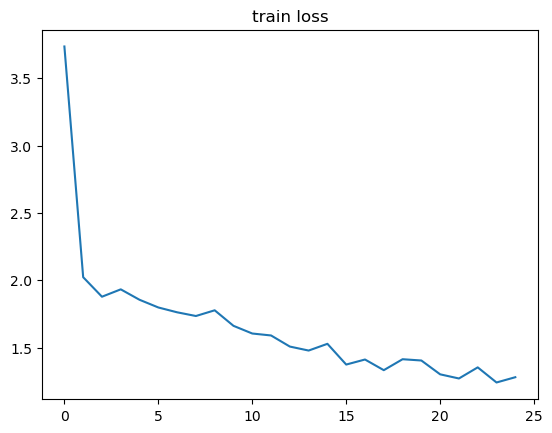

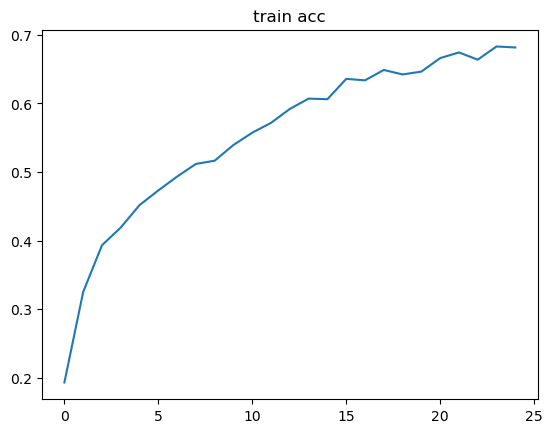

In [2]:
import torch
# max 1.5 eps 7.5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

batch_size=2048
adv_attack_mode ='batch'
epsilon=0.1
dp=True
epochs = 25
patience = 25
save_experiment=False 
verbose=True

adv_attack = None

experiment = Experiment(
    batch_size=batch_size, 
    epochs=epochs, 
    patience=patience, 
    adv_attack=adv_attack, 
    adv_attack_mode=None, 
    epsilon=epsilon, 
    dp=dp, 
    device=device, 
    save_experiment=save_experiment, 
    verbose=verbose, 
    adv_test=False)

experiment._fit()

In [3]:
experiment._validate(experiment.test_loader)

(1.3754646141065807, 0.6551, 0.9616)

cuda
Experiment non_adv+dp+2048: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment non_adv+dp+2048: DP on


/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Experiment non_adv+dp+2048: Training started


  0%|                                                                           | 0/25 [00:00<?, ?it/s]/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.56it/s]


1.4516589401482833
Experiment non_adv+dp+2048: Epoch   1/50, train loss: 3.66e+00, train acc: 0.187


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.66it/s]


1.747758124352123
Experiment non_adv+dp+2048: Epoch   2/50, train loss: 2.01e+00, train acc: 0.312


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.73it/s]


1.999566972341222
Experiment non_adv+dp+2048: Epoch   3/50, train loss: 1.96e+00, train acc: 0.370


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


2.224891133367204
Experiment non_adv+dp+2048: Epoch   4/50, train loss: 1.84e+00, train acc: 0.421


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


2.4316134424082634
Experiment non_adv+dp+2048: Epoch   5/50, train loss: 1.86e+00, train acc: 0.445


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.64it/s]


2.6240793638109987
Experiment non_adv+dp+2048: Epoch   6/50, train loss: 1.77e+00, train acc: 0.476


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.73it/s]


2.8048329218833166
Experiment non_adv+dp+2048: Epoch   7/50, train loss: 1.79e+00, train acc: 0.486


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


2.9761057507372533
Experiment non_adv+dp+2048: Epoch   8/50, train loss: 1.68e+00, train acc: 0.515


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


3.1394045326345137
Experiment non_adv+dp+2048: Epoch   9/50, train loss: 1.70e+00, train acc: 0.526


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


3.295542796385861
Experiment non_adv+dp+2048: Epoch  10/50, train loss: 1.71e+00, train acc: 0.532


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


3.446241126024633
Experiment non_adv+dp+2048: Epoch  11/50, train loss: 1.64e+00, train acc: 0.550


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


3.5910552602569976
Experiment non_adv+dp+2048: Epoch  12/50, train loss: 1.63e+00, train acc: 0.561


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


3.731449184805569
Experiment non_adv+dp+2048: Epoch  13/50, train loss: 1.59e+00, train acc: 0.573


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


3.8677404105245627
Experiment non_adv+dp+2048: Epoch  14/50, train loss: 1.56e+00, train acc: 0.584


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:15<00:00,  1.65it/s]


4.0002372672404105
Experiment non_adv+dp+2048: Epoch  15/50, train loss: 1.55e+00, train acc: 0.591


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


4.129252095818283
Experiment non_adv+dp+2048: Epoch  16/50, train loss: 1.50e+00, train acc: 0.603


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


4.255103895619909
Experiment non_adv+dp+2048: Epoch  17/50, train loss: 1.49e+00, train acc: 0.607


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.69it/s]


4.378121090275399
Experiment non_adv+dp+2048: Epoch  18/50, train loss: 1.45e+00, train acc: 0.618


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


4.498644475448194
Experiment non_adv+dp+2048: Epoch  19/50, train loss: 1.43e+00, train acc: 0.628


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.73it/s]


4.616850588007582
Experiment non_adv+dp+2048: Epoch  20/50, train loss: 1.42e+00, train acc: 0.634


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


4.732068073092045
Experiment non_adv+dp+2048: Epoch  21/50, train loss: 1.42e+00, train acc: 0.637


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


4.845575604666275
Experiment non_adv+dp+2048: Epoch  22/50, train loss: 1.36e+00, train acc: 0.649


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


4.957496826976863
Experiment non_adv+dp+2048: Epoch  23/50, train loss: 1.37e+00, train acc: 0.650


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


5.066624261602634
Experiment non_adv+dp+2048: Epoch  24/50, train loss: 1.38e+00, train acc: 0.653


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


5.174910099204971
Experiment non_adv+dp+2048: Epoch  25/50, train loss: 1.28e+00, train acc: 0.671


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


5.28074618858921
Experiment non_adv+dp+2048: Epoch  26/50, train loss: 1.35e+00, train acc: 0.665


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


5.385672864047911
Experiment non_adv+dp+2048: Epoch  27/50, train loss: 1.31e+00, train acc: 0.675


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


5.488536434999836
Experiment non_adv+dp+2048: Epoch  28/50, train loss: 1.29e+00, train acc: 0.679


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


5.590686394827535
Experiment non_adv+dp+2048: Epoch  29/50, train loss: 1.28e+00, train acc: 0.681


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


5.6906218085191655
Experiment non_adv+dp+2048: Epoch  30/50, train loss: 1.27e+00, train acc: 0.686


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


5.790557222210795
Experiment non_adv+dp+2048: Epoch  31/50, train loss: 1.26e+00, train acc: 0.690


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


5.88766830097423
Experiment non_adv+dp+2048: Epoch  32/50, train loss: 1.26e+00, train acc: 0.694


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


5.984718304571707
Experiment non_adv+dp+2048: Epoch  33/50, train loss: 1.26e+00, train acc: 0.694


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


6.080389667791101
Experiment non_adv+dp+2048: Epoch  34/50, train loss: 1.26e+00, train acc: 0.695


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


6.174595493956526
Experiment non_adv+dp+2048: Epoch  35/50, train loss: 1.27e+00, train acc: 0.698


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


6.268801320121951
Experiment non_adv+dp+2048: Epoch  36/50, train loss: 1.29e+00, train acc: 0.695


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


6.360958913287868
Experiment non_adv+dp+2048: Epoch  37/50, train loss: 1.21e+00, train acc: 0.710


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


6.452360371115347
Experiment non_adv+dp+2048: Epoch  38/50, train loss: 1.29e+00, train acc: 0.699


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


6.543761828942825
Experiment non_adv+dp+2048: Epoch  39/50, train loss: 1.21e+00, train acc: 0.713


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


6.633283961498917
Experiment non_adv+dp+2048: Epoch  40/50, train loss: 1.19e+00, train acc: 0.714


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


6.721919519815599
Experiment non_adv+dp+2048: Epoch  41/50, train loss: 1.20e+00, train acc: 0.716


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


6.81055507813228
Experiment non_adv+dp+2048: Epoch  42/50, train loss: 1.18e+00, train acc: 0.721


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


6.898401367063894
Experiment non_adv+dp+2048: Epoch  43/50, train loss: 1.26e+00, train acc: 0.709


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.70it/s]


6.98430823089281
Experiment non_adv+dp+2048: Epoch  44/50, train loss: 1.21e+00, train acc: 0.717


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


7.070215094721727
Experiment non_adv+dp+2048: Epoch  45/50, train loss: 1.15e+00, train acc: 0.729


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


7.156121958550642
Experiment non_adv+dp+2048: Epoch  46/50, train loss: 1.15e+00, train acc: 0.729


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


7.240657851908943
Experiment non_adv+dp+2048: Epoch  47/50, train loss: 1.15e+00, train acc: 0.729


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


7.323872032804464
Experiment non_adv+dp+2048: Epoch  48/50, train loss: 1.16e+00, train acc: 0.730


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.71it/s]


7.407086213699984
Experiment non_adv+dp+2048: Epoch  49/50, train loss: 1.12e+00, train acc: 0.738


100%|██████████████████████████████████████████████████████████████████| 25/25 [00:14<00:00,  1.72it/s]


7.490300394595504
Experiment non_adv+dp+2048: Epoch  50/50, train loss: 1.17e+00, train acc: 0.730
Experiment non_adv+dp+2048: Training finished
7.490300394595504


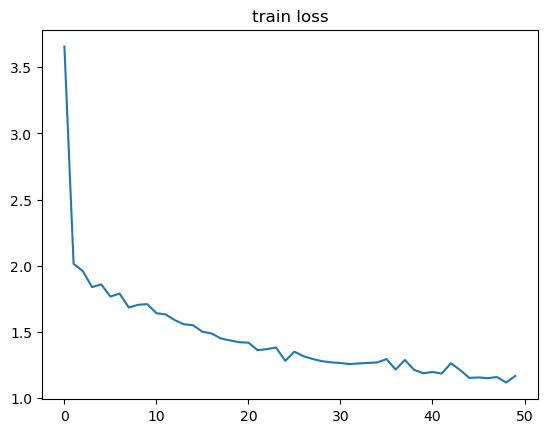

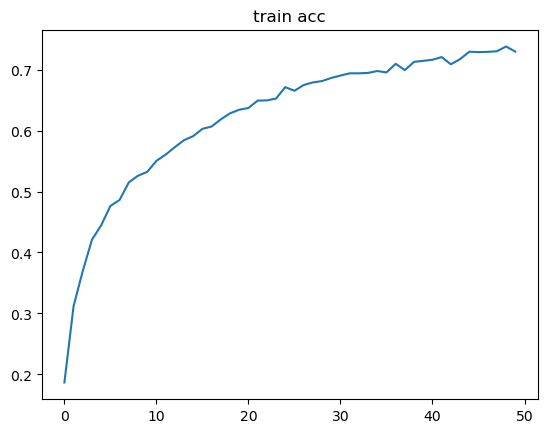

In [2]:
import torch
# max 1.2 eps 7.5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

batch_size=2048
adv_attack_mode ='batch'
epsilon=0.1
dp=True
epochs = 50
patience = 50
save_experiment=False 
verbose=True

adv_attack = None

experiment = Experiment(
    batch_size=batch_size, 
    epochs=epochs, 
    patience=patience, 
    adv_attack=adv_attack, 
    adv_attack_mode=None, 
    epsilon=epsilon, 
    dp=dp, 
    device=device, 
    save_experiment=save_experiment, 
    verbose=verbose, 
    adv_test=False)

experiment._fit()

In [3]:
experiment._validate(experiment.test_loader)

(1.3303881508045614, 0.697, 0.9726)

cuda
Experiment adv-0.1-batch+dp+2048: Loading data
Files already downloaded and verified
Files already downloaded and verified
Experiment adv-0.1-batch+dp+2048: DP on


/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/opacus/privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Experiment adv-0.1-batch+dp+2048: Training started


  0%|                                                                        | 0/25 [00:00<?, ?it/s]/home/anna/miniconda3/envs/ap/lib/python3.10/site-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|███████████████████████████████████████████████████████████████| 25/25 [00:22<00:00,  1.13it/s]


1.4516589401482833
Experiment adv-0.1-batch+dp+2048: Epoch   1/50, train loss: 3.90e+00, train acc: 0.105


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.28it/s]


1.747758124352123
Experiment adv-0.1-batch+dp+2048: Epoch   2/50, train loss: 2.40e+00, train acc: 0.172


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.28it/s]


1.999566972341222
Experiment adv-0.1-batch+dp+2048: Epoch   3/50, train loss: 2.31e+00, train acc: 0.214


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


2.224891133367204
Experiment adv-0.1-batch+dp+2048: Epoch   4/50, train loss: 2.30e+00, train acc: 0.234


100%|███████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.22it/s]


2.4316134424082634
Experiment adv-0.1-batch+dp+2048: Epoch   5/50, train loss: 2.22e+00, train acc: 0.250


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.28it/s]


2.6240793638109987
Experiment adv-0.1-batch+dp+2048: Epoch   6/50, train loss: 2.16e+00, train acc: 0.268


100%|███████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.22it/s]


2.8048329218833166
Experiment adv-0.1-batch+dp+2048: Epoch   7/50, train loss: 2.22e+00, train acc: 0.270


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


2.9761057507372533
Experiment adv-0.1-batch+dp+2048: Epoch   8/50, train loss: 2.12e+00, train acc: 0.279


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


3.1394045326345137
Experiment adv-0.1-batch+dp+2048: Epoch   9/50, train loss: 2.15e+00, train acc: 0.287


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


3.295542796385861
Experiment adv-0.1-batch+dp+2048: Epoch  10/50, train loss: 2.10e+00, train acc: 0.293


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.25it/s]


3.446241126024633
Experiment adv-0.1-batch+dp+2048: Epoch  11/50, train loss: 2.04e+00, train acc: 0.305


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


3.5910552602569976
Experiment adv-0.1-batch+dp+2048: Epoch  12/50, train loss: 2.15e+00, train acc: 0.294


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


3.731449184805569
Experiment adv-0.1-batch+dp+2048: Epoch  13/50, train loss: 2.07e+00, train acc: 0.308


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.25it/s]


3.8677404105245627
Experiment adv-0.1-batch+dp+2048: Epoch  14/50, train loss: 2.02e+00, train acc: 0.319


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


4.0002372672404105
Experiment adv-0.1-batch+dp+2048: Epoch  15/50, train loss: 2.05e+00, train acc: 0.318


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


4.129252095818283
Experiment adv-0.1-batch+dp+2048: Epoch  16/50, train loss: 2.04e+00, train acc: 0.325


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


4.255103895619909
Experiment adv-0.1-batch+dp+2048: Epoch  17/50, train loss: 2.01e+00, train acc: 0.333


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


4.378121090275399
Experiment adv-0.1-batch+dp+2048: Epoch  18/50, train loss: 2.03e+00, train acc: 0.328


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


4.498644475448194
Experiment adv-0.1-batch+dp+2048: Epoch  19/50, train loss: 1.99e+00, train acc: 0.335


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


4.616850588007582
Experiment adv-0.1-batch+dp+2048: Epoch  20/50, train loss: 2.01e+00, train acc: 0.335


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


4.732068073092045
Experiment adv-0.1-batch+dp+2048: Epoch  21/50, train loss: 1.99e+00, train acc: 0.340


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


4.845575604666275
Experiment adv-0.1-batch+dp+2048: Epoch  22/50, train loss: 1.97e+00, train acc: 0.346


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


4.957496826976863
Experiment adv-0.1-batch+dp+2048: Epoch  23/50, train loss: 1.98e+00, train acc: 0.351


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


5.066624261602634
Experiment adv-0.1-batch+dp+2048: Epoch  24/50, train loss: 2.01e+00, train acc: 0.346


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


5.174910099204971
Experiment adv-0.1-batch+dp+2048: Epoch  25/50, train loss: 1.96e+00, train acc: 0.358


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.25it/s]


5.28074618858921
Experiment adv-0.1-batch+dp+2048: Epoch  26/50, train loss: 1.96e+00, train acc: 0.357


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


5.385672864047911
Experiment adv-0.1-batch+dp+2048: Epoch  27/50, train loss: 1.99e+00, train acc: 0.355


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


5.488536434999836
Experiment adv-0.1-batch+dp+2048: Epoch  28/50, train loss: 1.93e+00, train acc: 0.367


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


5.590686394827535
Experiment adv-0.1-batch+dp+2048: Epoch  29/50, train loss: 1.94e+00, train acc: 0.368


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


5.6906218085191655
Experiment adv-0.1-batch+dp+2048: Epoch  30/50, train loss: 1.98e+00, train acc: 0.363


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


5.790557222210795
Experiment adv-0.1-batch+dp+2048: Epoch  31/50, train loss: 1.94e+00, train acc: 0.373


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


5.88766830097423
Experiment adv-0.1-batch+dp+2048: Epoch  32/50, train loss: 1.94e+00, train acc: 0.373


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


5.984718304571707
Experiment adv-0.1-batch+dp+2048: Epoch  33/50, train loss: 1.94e+00, train acc: 0.377


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


6.080389667791101
Experiment adv-0.1-batch+dp+2048: Epoch  34/50, train loss: 1.92e+00, train acc: 0.378


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


6.174595493956526
Experiment adv-0.1-batch+dp+2048: Epoch  35/50, train loss: 1.97e+00, train acc: 0.371


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


6.268801320121951
Experiment adv-0.1-batch+dp+2048: Epoch  36/50, train loss: 1.90e+00, train acc: 0.383


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.28it/s]


6.360958913287868
Experiment adv-0.1-batch+dp+2048: Epoch  37/50, train loss: 1.96e+00, train acc: 0.379


100%|███████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.23it/s]


6.452360371115347
Experiment adv-0.1-batch+dp+2048: Epoch  38/50, train loss: 1.91e+00, train acc: 0.387


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


6.543761828942825
Experiment adv-0.1-batch+dp+2048: Epoch  39/50, train loss: 1.93e+00, train acc: 0.384


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


6.633283961498917
Experiment adv-0.1-batch+dp+2048: Epoch  40/50, train loss: 1.89e+00, train acc: 0.394


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


6.721919519815599
Experiment adv-0.1-batch+dp+2048: Epoch  41/50, train loss: 1.96e+00, train acc: 0.386


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


6.81055507813228
Experiment adv-0.1-batch+dp+2048: Epoch  42/50, train loss: 1.91e+00, train acc: 0.397


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


6.898401367063894
Experiment adv-0.1-batch+dp+2048: Epoch  43/50, train loss: 1.92e+00, train acc: 0.395


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


6.98430823089281
Experiment adv-0.1-batch+dp+2048: Epoch  44/50, train loss: 1.96e+00, train acc: 0.389


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


7.070215094721727
Experiment adv-0.1-batch+dp+2048: Epoch  45/50, train loss: 1.90e+00, train acc: 0.401


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


7.156121958550642
Experiment adv-0.1-batch+dp+2048: Epoch  46/50, train loss: 1.90e+00, train acc: 0.402


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


7.240657851908943
Experiment adv-0.1-batch+dp+2048: Epoch  47/50, train loss: 1.93e+00, train acc: 0.399


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


7.323872032804464
Experiment adv-0.1-batch+dp+2048: Epoch  48/50, train loss: 1.86e+00, train acc: 0.413


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


7.407086213699984
Experiment adv-0.1-batch+dp+2048: Epoch  49/50, train loss: 1.88e+00, train acc: 0.408


100%|███████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.26it/s]


7.490300394595504
Experiment adv-0.1-batch+dp+2048: Epoch  50/50, train loss: 1.91e+00, train acc: 0.407
Experiment adv-0.1-batch+dp+2048: Training finished
7.490300394595504


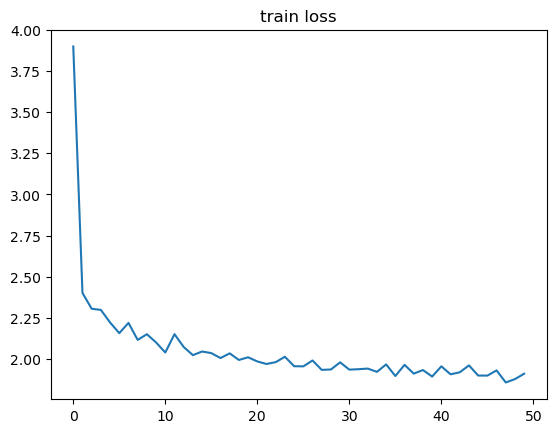

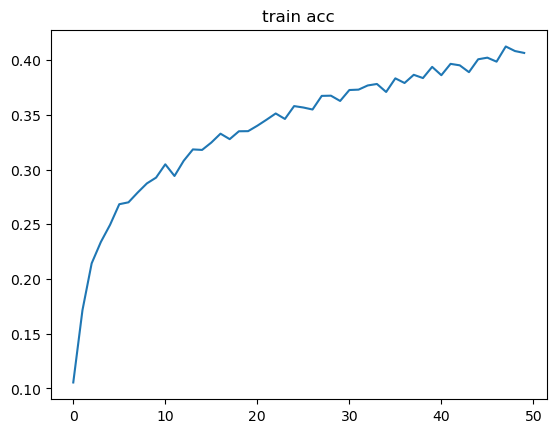

In [2]:
import torch
# max 1.2 eps 7.5

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

batch_size=2048
adv_attack_mode ='batch'
epsilon=0.1
dp=True
epochs = 50
patience = 50
save_experiment=False 
verbose=True

adv_attack = True

experiment = Experiment(
    batch_size=batch_size, 
    epochs=epochs, 
    patience=patience, 
    adv_attack=adv_attack, 
    adv_attack_mode=adv_attack_mode, 
    epsilon=epsilon, 
    dp=dp, 
    device=device, 
    save_experiment=save_experiment, 
    verbose=verbose, 
    adv_test=True)

experiment._fit()

In [3]:
experiment._validate(experiment.test_loader)

(2.3716866134772236, 0.411, 0.8518)